# Séance 2 - Réseau de neurones convolutionnel

On se propose de classifier les chiffres manuscrit du dataset [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) en définissant ses propres réseaux de neurones convolutionnel. L'objectif est de découvrir la manière d'entraîner ces algorithmes et observer en pratique les bases théoriques discutées en cours.

## Exploration des données

Commençons par importer les données.

In [27]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

(X_train_full, y_train_full), (X_test, y_test) = (keras.datasets.fashion_mnist.load_data())

**Consigne** : À l'aide de la fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), séparer le jeu d'entraînement complet en un dataset d'entraînement et un dataset de validation. Afficher les tailles des datasets respectifs.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(48000, 28, 28) (48000,)
(12000, 28, 28) (12000,)


Les classes sont encore des nombres, mais ils correspondent à une catégorie. Pour mieux visualiser, nous allons faire un dictionnaire.

In [29]:
label_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

**Consigne** : Afficher plusieurs images du dataset d'entraînement aléatoirement. On pourra utiliser la fonction [`imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) et le dictionnaire.

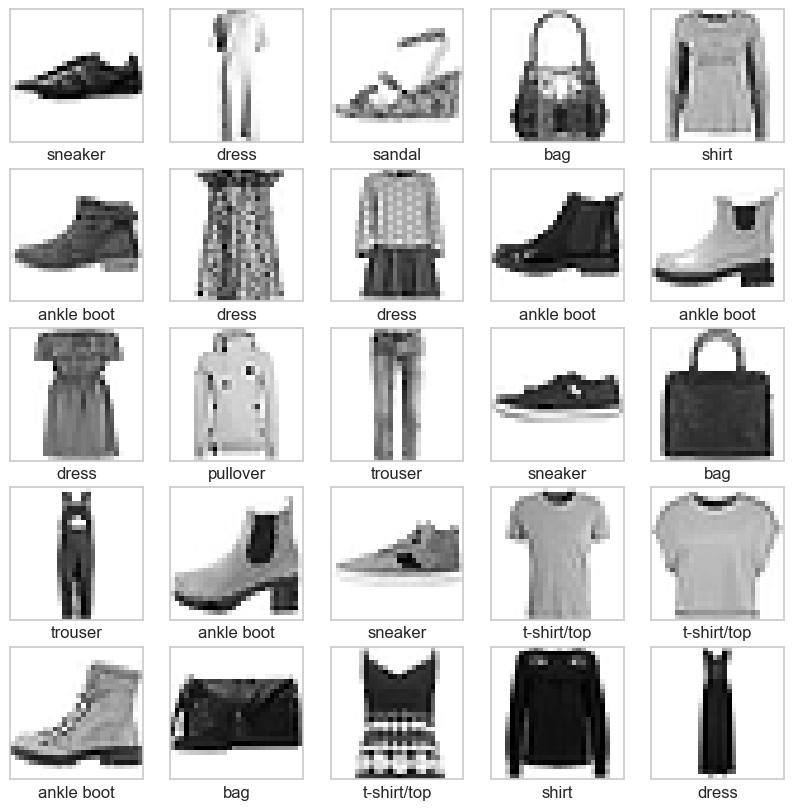

In [30]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(label_map[y_train[i]])
plt.show()

**Consigne** : Standardiser les données en utilisant la classe [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). On commencera par applatir les images en utilisant la méthode [`reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html), puis on applique le pré-processing et on termine par reformer la matrice.

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(np.float32)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1).astype(np.float32)
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(np.float32)

X_train = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_valid = scaler.transform(X_valid_flat).reshape(X_valid.shape)
X_test = scaler.transform(X_test_flat).reshape(X_test.shape)

## Modélisation

On veut définir le réseau suivant:
* Deux convolutions avec 32 filtres 3x3 en conservant la taille. On utilisera la couche [`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)
* Une couche max pooling avec un filtre 2x2 et 2 de stride. On utilisera la couche [`MaxPool2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
* Une couche [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) puis un réseau dense de 64 neurones
* Une couche de sortie à 10 neurones

**Consigne** : Définir le réseau souhaité. On sélectionnera la fonction d'activation et la distribution initiale des poids adaptées.

In [32]:
model = keras.models.Sequential(
    [
        keras.layers.Input(shape=(28, 28, 1)),
        keras.layers.Conv2D(
            filters=32, kernel_size=3, activation="relu", padding="same"
        ),
        keras.layers.Conv2D(
            filters=32, kernel_size=3, activation="relu", padding="same"
        ),
        keras.layers.MaxPooling2D(pool_size=2, strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=64, activation="relu"),
        keras.layers.Dense(units=10, activation="softmax"),
    ]
)


**Consigne** : Calculer le nombre de paramètre du réseau de neurones à la main, puis vérifier avec la méthode [`summary`](https://keras.io/api/models/model/#summary-method).

In [33]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,690 (1.57 MB)

 Trainable params: 411,690 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

**Consigne** : Lancer l'entraînement avec les paramètres adaptés sur quelques époque pour vérifier son fonctionnement.

In [34]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_valid, y_valid),
    verbose=2,
)

Epoch 1/5
750/750 - 17s - 22ms/step - accuracy: 0.8602 - loss: 0.3948 - val_accuracy: 0.8903 - val_loss: 0.2993
Epoch 2/5
750/750 - 15s - 20ms/step - accuracy: 0.9103 - loss: 0.2474 - val_accuracy: 0.9101 - val_loss: 0.2474
Epoch 3/5
750/750 - 15s - 20ms/step - accuracy: 0.9290 - loss: 0.1945 - val_accuracy: 0.9115 - val_loss: 0.2397
Epoch 4/5
750/750 - 17s - 23ms/step - accuracy: 0.9442 - loss: 0.1528 - val_accuracy: 0.9158 - val_loss: 0.2382
Epoch 5/5
750/750 - 17s - 22ms/step - accuracy: 0.9566 - loss: 0.1183 - val_accuracy: 0.9103 - val_loss: 0.2720


## Couche BatchNormalization

On souhaite mesurer l'apport de la couche [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) à un réseau de neurone. Pour cela, on se propose de faire une étude comparative sur le modèle que nous venons de définir. Nous nous proposons de placer la couche BatchNormalization uniquement entre les deux couches de convolution.

**Consigne** : Définir une fonction `get_model` qui prend en paramètre:
* *normalization*: un booléen indiquant si la couche [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) doit être présente dans le modèle
* *learning_rate*: un flottant correspondant au learning rate souhaité

La fonction renvoie un modèle compilé.

In [35]:
def get_model(normalization: bool, learning_rate: float) -> keras.Model:
    if normalization:
        model = keras.models.Sequential(
            [
                keras.layers.Input(shape=(28, 28, 1)),
                keras.layers.Conv2D(
                    filters=32, kernel_size=3, activation="relu", padding="same"
                ),
                keras.layers.BatchNormalization(),
                keras.layers.Conv2D(
                    filters=32, kernel_size=3, activation="relu", padding="same"
                ),
                keras.layers.MaxPooling2D(pool_size=2, strides=2),
                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),
                keras.layers.Dense(units=10, activation="softmax"),
            ]
        )
    else:
        model = keras.models.Sequential(
            [
                keras.layers.Input(shape=(28, 28, 1)),
                keras.layers.Conv2D(
                    filters=32, kernel_size=3, activation="relu", padding="same"
                ),
                keras.layers.Conv2D(
                    filters=32, kernel_size=3, activation="relu", padding="same"
                ),
                keras.layers.MaxPooling2D(pool_size=2, strides=2),
                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),
                keras.layers.Dense(units=10, activation="softmax"),
            ]
        )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

**Consigne** : Combien de paramètre un modèle avec la couche de [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) a-t-il ? Est-ce équivalent à un modèle sans [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) ? 

In [36]:
model_normalized = get_model(normalization=True, learning_rate=1e-3)

model_normalized.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,818 (1.57 MB)

 Trainable params: 411,754 (1.57 MB)

 Non-trainable params: 64 (256.00 B)

Pour s'affranchir un peu de l'aléatoire, nous proposons de lancer trois fois les deux types de modèles pour les comparer.

**Consigne** : Écrire une boucle d'entraînement qui va stocker dans une liste les courbes d'apprentissage. Chaque élément de la liste correspondra à un dictionnaire avec pour clé:
* *type*: le type du réseau (avec ou sans BatchNormalization)
* *history*: l'historique d'apprentissage

In [ ]:
training_curves = []

num_trainings = 3
epochs = 5
batch_size = 64

for normalized in [True, False]:
    for _ in range(num_trainings):
        model = get_model(normalization=normalized, learning_rate=1e-3)
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_valid, y_valid),
        )
        training_curves.append({
            'history': history,
            'normalization': normalized
        })

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8519 - loss: 0.4220 - val_accuracy: 0.8890 - val_loss: 0.3176
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9057 - loss: 0.2612 - val_accuracy: 0.9048 - val_loss: 0.2682
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9229 - loss: 0.2076 - val_accuracy: 0.9071 - val_loss: 0.2575
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9386 - loss: 0.1689 - val_accuracy: 0.9178 - val_loss: 0.2389
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9499 - loss: 0.1365 - val_accuracy: 0.9142 - val_loss: 0.2515
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8575 - loss: 0.4019 - val_accuracy: 0.8900 - val_loss: 0.2951
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9098 - loss: 0.2486 - val_accuracy: 0.9018 - val_loss: 0.2785
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9287 - loss: 0.1943 - val_accu

Il faut maintenant visualiser les résultats. Commençons par préparer les données.

**Consigne** : Définir une fonction `agregate_result` qui prend en paramètre:
* *results*: le dictionnaire de résultat, au format décrit précédemment
* *network_type*: chaîne de caractère identifiant le type de réseau
* *metric_name*: le nom de la métrique d'intérêt

La fonction renverra deux matrices de tailles (nombre de comparaisons, nombre d'époque) : une pour le dataset d'entraînement et une pour le dataset de validation. On concatène donc les différentes courbes d'apprentissage.

**Consigne** : Visualiser les courbes d'apprentissage en faisant apparaître des intervals de confiance. On prendra exemple sur la fonction `show_results` du TP précédent. Commenter.

## Pour continuer

Choisir une ou plusieurs pistes de recherche parmi les suivantes. Il est possible de choisir une autre direction, mais elle doit être validé auparavant.

1. Nous avons utilisé la couche [`MaxPool2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/), mais on peut se poser la question de l'utilisation de la couche [`AveragePooling2D`](https://keras.io/api/layers/pooling_layers/average_pooling2d/) voire l'absence de couche de pooling.
2. Nous avons vu en cours qu'une agencement particulier de couches permet d'avoir les meilleurs performance pour la compétition ImageNet: les ResNet. Comment écrire un réseau résiduel à la main ?
3. Dans un [billet de blog](https://www.rpisoni.dev/posts/cossim-convolution/) est proposée une alternative à la couche convolutionnelle traditionnelle. On se propose de l'implémenter et d'explorer ses capacités.